## 一、q-learning提出的背景


    q的含义是quality，也就是状态动作对的质量。这一算法在环境model未知的情况下进行策略评估的框架算法
    是一种off-policy的策略算法，也就是说他通过别的策略产生的trajectory去迭代当前策略。


## 二、q-learning算法的核心
    通过从经验episode中学习迭代Q表，使用ε-greedy策略去选择行为。
    更新规则基于贝尔曼最优方程
$$Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$
## 算法伪代码


![算法代码](img.png "算法代码")


## 三、下面通过一个例子，q-learning算法走25*25迷宫的例子来测试q-learning算法




In [110]:
import matplotlib.pyplot as plt

#使用 matplotlib来绘制迷宫
def plot_world(world, stone_list, start_position, final_position, result=None):
    plt.figure(1)

    plt.ylim([0, len(world)-1])
    plt.xlim([0, len(world)-1])
    plt.xticks([i for i in range(len(world))], [str(i) for i in range(len(world))])
    plt.yticks([i for i in range(len(world))], [str(i) for i in range(len(world))])
    plt.grid()
    plt.title("grid world")
    plt.scatter(start_position[0], start_position[1], s=150, color="green", marker="s")
    plt.scatter(final_position[0], final_position[1], s=150, color="red", marker="o")
    for eve in stone_list:
        plt.scatter(eve[0], eve[1], s=150, color="gray", marker="x")
    if result != None:
        for i in range(len(result)-1):
            plt.plot([result[i][0], result[i+1][0]], [result[i][1], result[i+1][1]], color="red", marker="*")
        plt.savefig("qlearning-grid-result.png", dpi=600)
        plt.show()
    else:
        plt.savefig("grid.png", dpi=600)
        plt.show()

## 初始化地图、障碍、目标、起点

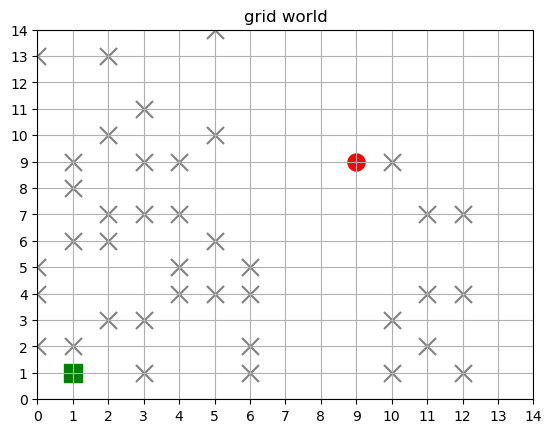

In [111]:

world = [[(i,j) for j in range(15)] for i in range(15)]
# 设置11个障碍物
stone_list = [(0, 2), (0, 4), (0, 5), (0, 13), (0, 19), (0, 20), (0, 22), (1, 2), (1, 6), (1, 8), (1, 9), (1, 15), (1, 17), (1, 19), (2, 3), (2, 6), (2, 7), (2, 10), (2, 13), (2, 17), (2, 19), (3, 1), (3, 3), (3, 7), (3, 9), (3, 11), (3, 16), (3, 18), (4, 4), (4, 5), (4, 7), (4, 9), (4, 21),  (5, 4), (5, 6), (5, 10), (5, 14), (5, 15), (5, 17), (5, 23), (6, 1), (6, 2), (6, 4), (6, 5),(10,1),(10,3),(10,9),(11,2),(11,4),(11,7),(12,1),(12,7),(12,4),(12,18),(12,19)]
# 设置入口与出口
start_position = (1, 1)
final_position = (9, 9)
plot_world(world,stone_list,start_position,final_position)

## 奖励函数

In [112]:
def get_reward(state, final_position, stone_list, current_state):
    if state == current_state:
        return -3
    if state == final_position:
        return 10
    elif state in stone_list:
        return -10
    else:
        return -1

## 根据当前(s,a)，决定下一时刻的状态

In [113]:
def action_result(action, current_state, max_trick):
    if action == "up":
        if current_state[1] == max_trick:
            return current_state
        else:
            return (current_state[0], current_state[1]+1)
    elif action == "down":
        if current_state[1] == 0:
            return current_state
        else:
            return (current_state[0], current_state[1]-1)
    elif action == "left":
        if current_state[0] == 0:
            return current_state
        else:
            return (current_state[0]-1, current_state[1])
    elif action == "right":
        if current_state[0] == max_trick:
            return current_state
        else:
            return (current_state[0]+1, current_state[1])
    else:
        raise IOError

## 从q表获取最大q值

In [114]:
# 获得最大的q值
def get_maxq(qtable, state):
    temp = []
    for i in range(len(qtable)):
        temp.append(qtable[i][state[0]][state[1]])
    maxone = max(temp)
    argmax = np.argmax(temp)
    return maxone, argmax

## 参数初始化

In [115]:
# 动作空间
action = ["up", "down", "left", "right"]
episodes = 600
alpha = 0.7
gamma = 0.5
epsilon = 0.5

# q表和策略初始化，初值都是0
q_table = [[[0 for j in range(len(world))] for i in range(len(world))] for k in range(4)]
policy = [[0 for j in range(len(world))] for i in range(len(world))]


## 打印策略内容

In [116]:
def print_policy(policy_, stone_list, final_position):
    with open('qlearning-policy.txt', "w", encoding="utf-8") as f:
        for x in range(len(policy_)):
            for y in range(len(policy_[x])):
                if (x, y) in stone_list:
                    print("({},{}):{}".format(x, y, "障碍物"), end="; ", file=f)
                    print("({},{}):{}".format(x, y, "障碍物"), end="; ")
                elif (x, y) == final_position:
                    print("({},{}):{}".format(x, y, "终点"), end="; ", file=f)
                    print("({},{}):{}".format(x, y, "终点"), end="; ")
                else:
                    print("({},{}):{}".format(x, y, action[policy_[x][y]]), end="; ", file=f)
                    print("({},{}):{}".format(x, y, action[policy_[x][y]]), end="; ")
            print("", file=f)
            print("")


## 训练和推理

begin: (1, 1);(2, 1);(2, 2);(3, 2);(4, 2);(5, 2);(5, 3);(6, 3);(7, 3);(7, 4);(7, 5);(8, 5);(9, 5);(9, 6);(9, 7);(9, 8);(9, 9);bingo!
共走了 16 步


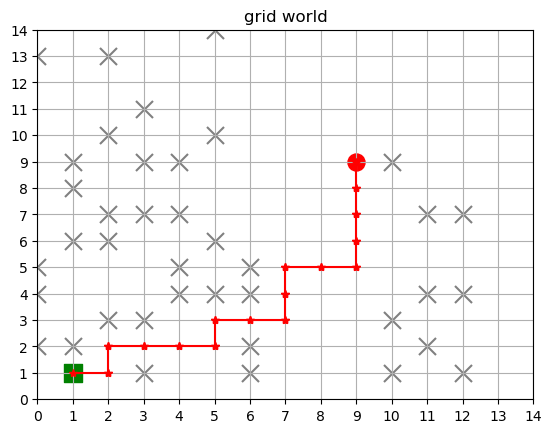

使用q-learning训练并推理产生的结果图见根目录'qlearning-grid-result.png'
使用q-learning训练并推理产生的策略已保存在'qlearning-policy.txt'
q-learning策略：
(0,0):right; (0,1):right; (0,2):障碍物; (0,3):up; (0,4):障碍物; (0,5):障碍物; (0,6):up; (0,7):up; (0,8):up; (0,9):up; (0,10):up; (0,11):up; (0,12):up; (0,13):障碍物; (0,14):up; 
(1,0):right; (1,1):right; (1,2):障碍物; (1,3):up; (1,4):up; (1,5):up; (1,6):障碍物; (1,7):up; (1,8):障碍物; (1,9):障碍物; (1,10):up; (1,11):up; (1,12):up; (1,13):up; (1,14):up; 
(2,0):right; (2,1):up; (2,2):right; (2,3):障碍物; (2,4):up; (2,5):up; (2,6):障碍物; (2,7):障碍物; (2,8):up; (2,9):up; (2,10):障碍物; (2,11):up; (2,12):up; (2,13):障碍物; (2,14):up; 
(3,0):right; (3,1):障碍物; (3,2):right; (3,3):障碍物; (3,4):up; (3,5):up; (3,6):up; (3,7):障碍物; (3,8):up; (3,9):障碍物; (3,10):up; (3,11):障碍物; (3,12):up; (3,13):up; (3,14):up; 
(4,0):right; (4,1):up; (4,2):right; (4,3):right; (4,4):障碍物; (4,5):障碍物; (4,6):up; (4,7):障碍物; (4,8):up; (4,9):障碍物; (4,10):up; (4,11):up; (4,12):up; (4,13):up; (4,14):up; 
(5,0):right; (5,1):up; (5,2):up; (5,3):right; (

In [117]:
import numpy as np
import random
# 训练
for episode in range(episodes):
    current_state = start_position
    save = [current_state]
    while True:
        # 策略选择动作
        if random.randint(1,100)/100 > epsilon:
            action_index = policy[current_state[0]][current_state[1]]
        else:
            action_index = random.randint(0,3)
        next_state = action_result(action[action_index], current_state, 11)
        reward = get_reward(next_state, final_position, stone_list, current_state)

        # 更新q值表
        maxone, _ = get_maxq(q_table, next_state)
        q_table[action_index][current_state[0]][current_state[1]] += \
            alpha*(reward + gamma*maxone - q_table[action_index][current_state[0]][current_state[1]])
        # 更新策略
        _, argmax = get_maxq(q_table, current_state)
        policy[current_state[0]][current_state[1]] = argmax

        # 时间步长改变
        current_state = next_state
        save.append(current_state)
        if reward == 10 or reward == -10:
            # print(save)
            break

# 推理
state = start_position
res = [state]
print("begin:", state, end=";")
for i in range(20):
    a_index = policy[state[0]][state[1]]
    next_state = action_result(action[a_index], state, 11)
    print(next_state, end=";")
    res.append(next_state)
    if next_state == final_position:
        print("bingo!")
        print("共走了",i+1,"步")
        plot_world(world, stone_list, start_position, final_position,res)
        print("使用q-learning训练并推理产生的结果图见根目录'qlearning-grid-result.png'")
        print("使用q-learning训练并推理产生的策略已保存在'qlearning-policy.txt'")
        print("q-learning策略：")
        print_policy(policy, stone_list, final_position)
        break
    state = next_state
